In [1]:
# coding: utf-8
"""
コードテストをするためのコード
"""
from filer2.filer2 import Filer
from library.submodular import SubModular, Vector, GraphSubModular
import collections
import numpy as np
from scipy.spatial.distance import cosine, sqeuclidean
from scipy.sparse import csr_matrix, vstack, lil_matrix
import matplotlib.pylab as plt
% pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# 関数の定義
def cal_cost(list_c_word, distance_matrix, scale):
    """
    コスト１回分の計算
    """
    # 単語をidに変換
    list_c_id = sorted([dict_word_id[word] for word in list_c_word])
    dm = distance_matrix[:,list_c_id]
    f_C = 0.0
    for row in dm:
        if scale == 0:
            f_C -= np.exp(np.amin(row))
        elif scale == 1:
            f_C -= np.amin(row)
        else:
            f_C -= np.log(np.amin(row))
    return f_C

def greedy_1(list_C, list_id_document, distance_matrix, r=1, scale=0):
    """
    修正貪欲法のone loopのためのコード
    list_C: 要約文書の集合
    list_document: 追加する文書候補の集合
    distance_matrix: 各ノード間の距離, W * V
    r: コストに追加するハイパーパラメータ
    scale: scale関数、0: e^x, 1: x, 2: ln_x
    """
    # 現在のコストを計算
    
    # 一番初めの時
    if len(list_C) == 0:
        list_id_score = []
        for doc_id, document in list_id_document:
            list_c_word = sorted(list(set([word for word in document])))
            f_C = cal_cost(list_c_word, distance_matrix, scale)
            f_C /= (np.power(len(document), r))
            list_id_score.append([[doc_id, document], f_C])
        doc, _ = sorted(list_id_score, key=lambda x:x[1], reverse=True)[0]
        return doc
    else:
        # 単語のuniqueなリストを作成、単語をidに変換
        list_c_word = sorted(list(set([word for row in list_C for word in row[1]])))
        # f_C: 現在のコストの計算
        f_C = cal_cost(list_c_word, distance_matrix, scale)
        print f_C
        # 文書を１つずつ追加した時のコストの増分を計算
        list_id_score = []
        for doc_id, document in list_id_document:
            # 文章の追加
            list_c_word_s = list(set(list_c_word + document))
            # コストの計算
            f_C_s = cal_cost(list_c_word_s, distance_matrix, scale)
            # スコアの増分を計算
            delta = (f_C_s - f_C)/(np.power(len(document), r))
            list_id_score.append([[doc_id, document], delta])
        # スコアの増分が一番大きかったdocを返す
        doc, _ = sorted(list_id_score, key=lambda x:x[1], reverse=True)[0]
        return doc

def greedy(list_id_document, matrix, num_s = 5, r=1, scale=0):
    """
    修正貪欲法で文章の抽出を行うための関数
    list_id_document: 文idとbag of wordsが記録されたリスト
    matrix: ノード間の距離を記録したmatrix, V * V, numpy_array
    num_s: 抜き出したい文章数
    r: 文の長さに対するコスト
    scale: scale関数として何を使うか、0: e^x, 1: x, 2: ln_x
    """
    # 対角成分を0にする
    for i, row in enumerate(matrix):
        matrix[i][i] = 0.0
    # matrixをdistance_matrixに変換
    list_row = [matrix[dict_word_id[word]] for row in list_id_document for word in row[1]]
    distance_matrix = np.vstack(list_row)
    # 要約文章の集合
    list_C = []
    while len(list_C) < num_s:
        doc_id, doc = greedy_1(list_C=list_C,
                               list_id_document=list_id_document,
                               distance_matrix=distance_matrix,
                               r=r, scale=scale)
        list_C.append([doc_id, doc])
        list_id_document.remove([doc_id, doc])
    return list_C

### 動作確認

In [3]:
list_bag = []
elements = [i for i in range(60)]
weight_high = [2.5 for i in range(20)]
weight_middle = [2 for i in range(20)]
weight_low = [1.5 for i in range(20)]
weights = weight_high + weight_middle + weight_low
weights = np.array(weights)/float(np.sum(weights))

for i in range(40):
    list_tmp = []
    for j in range(4):
        list_tmp.append(np.random.choice(elements, p=weights))
    list_bag.append(list_tmp)
list_bag = [[str(num) for num in row] for row in list_bag]
list_id_document = [[i, row] for i, row in enumerate(list_bag)]
SM = SubModular(list_bag)
matrix = SM._cal_matrix_path_out(inverse_flag=True, weight=5)
dict_word_id = SM._dict_word_id
list_C = greedy(list_id_document, matrix, num_s = 5, r=1, scale=0)

-3304.70034887
-1039.91574261
-650.204457688
-485.062858572


library/submodular.py:155: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:4482
  output='epath')


In [4]:
list_C

[[37, ['19', '2', '58', '30']],
 [3, ['51', '10', '37', '43']],
 [16, ['17', '31', '0', '7']],
 [8, ['6', '44', '40', '39']],
 [11, ['9', '40', '4', '45']]]

In [5]:
SM = SubModular(list_bag)
SM.m_greedy(num_s=5, r=1, scale=0)

-3304.70034887
-1039.91574261
-650.204457688
-485.062858572


In [8]:
SM.list_C

property: list_C


[[37, ['19', '2', '58', '30']],
 [3, ['51', '10', '37', '43']],
 [16, ['17', '31', '0', '7']],
 [8, ['6', '44', '40', '39']],
 [11, ['9', '40', '4', '45']]]

In [9]:
list_edgelist = []
for row in list_bag:
    for i in range(len(row)-1):
        list_edgelist.append((row[i], row[i+1]))

list_edge = []
for edge, weight in collections.Counter(list_edgelist).items():
    list_edge.append([edge, weight])

In [10]:
list_node = sorted(list(set([node for row in list_edge for node in row[0]])))

In [12]:
import networkx as nx
Graph = nx.DiGraph()
Graph.add_nodes_from(list_node)
for row in list_edge:
    Graph.add_edge(row[0][0], row[0][1], weight=row[1])

In [13]:
pos = nx.spring_layout(Graph)

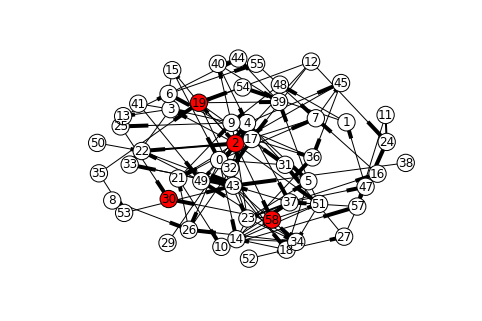

In [19]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

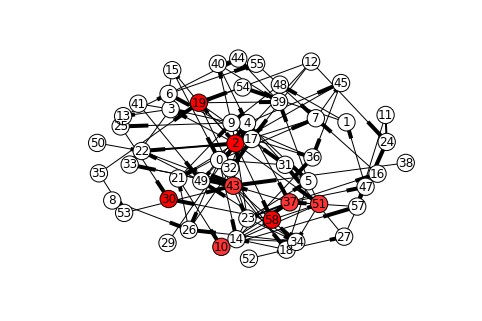

In [24]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

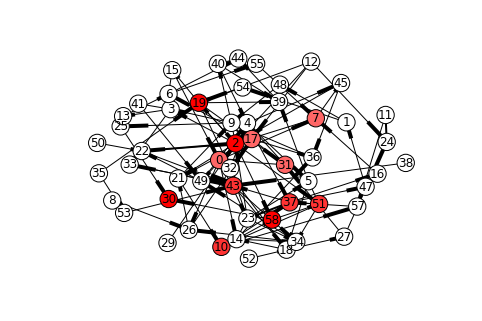

In [25]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

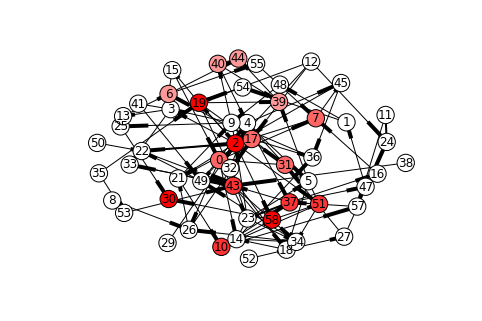

In [26]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[3][1]:
        listcolor.append('#ff9999')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

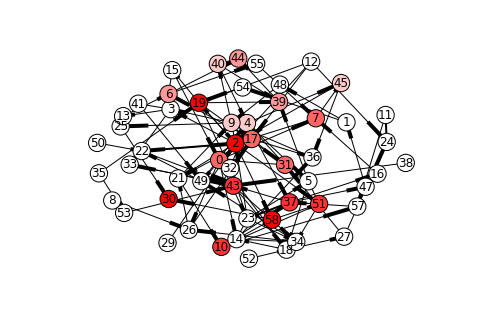

In [27]:
plt.figure()
#nx.draw_networkx_nodes(Graph, pos, node_size=200, node_color='white')
listcolor = []
for num in Graph.nodes():
    if num in list_C[4][1]:
        listcolor.append('#ffcccc')
    elif num in list_C[3][1]:
        listcolor.append('#ff9999')
    elif num in list_C[2][1]:
        listcolor.append('#ff6666')
    elif num in list_C[1][1]:
        listcolor.append('#ff3333')
    elif num in list_C[0][1]:
        listcolor.append('#ff0000')
    else:
        listcolor.append('w')
weights = [Graph[u][v]['weight'] for u,v in Graph.edges()]
nx.draw(Graph, pos, with_labels=True, node_color=listcolor, width=weights*10)
plt.show()

In [2]:
### コードテスト

In [ ]:
SM = SubModular()